# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import random
from glob import glob
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
%matplotlib inline
# create a image generator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go
from tensorflow.keras import regularizers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

In [3]:
data_map = []
for sub_dir_path in glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [4]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [5]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_44.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_44_mask.tif


In [6]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
'''pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 50)'''
brain_df



patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                                                                           image_path  \
0      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif   
1      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif   
2      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif   
3      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif   
4      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif   
...                                                                                               ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86.tif   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87.tif   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88.tif   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88.tif   

                                                                                                 mask_path  \
0      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif   
1      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif   
2      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif   
3      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif   
4      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif   
...                                                                                                    ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88_mask.tif   

      mask  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
3924     0  
3925     0  
3926     0  
3927     0  
3928     0  

[3929 rows x 4 columns]

# Phân loại

In [7]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [8]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [9]:
batch_size = 16
epochs = 100
image_size = 256

In [10]:
# split the data into train and test data
train, test = train_test_split(brain_df_train, test_size = 0.2)
# create a image generator
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
train_datagen  = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.3,
    rotation_range=20,            # Rotate images by 20 degrees
    width_shift_range=0.1,        # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,       # Randomly shift images vertically by 10% of the height
    zoom_range=0.2,               # Apply random zooming in the range of 0.8 to 1.2
    horizontal_flip=True         # Flip images horizontally
)
     

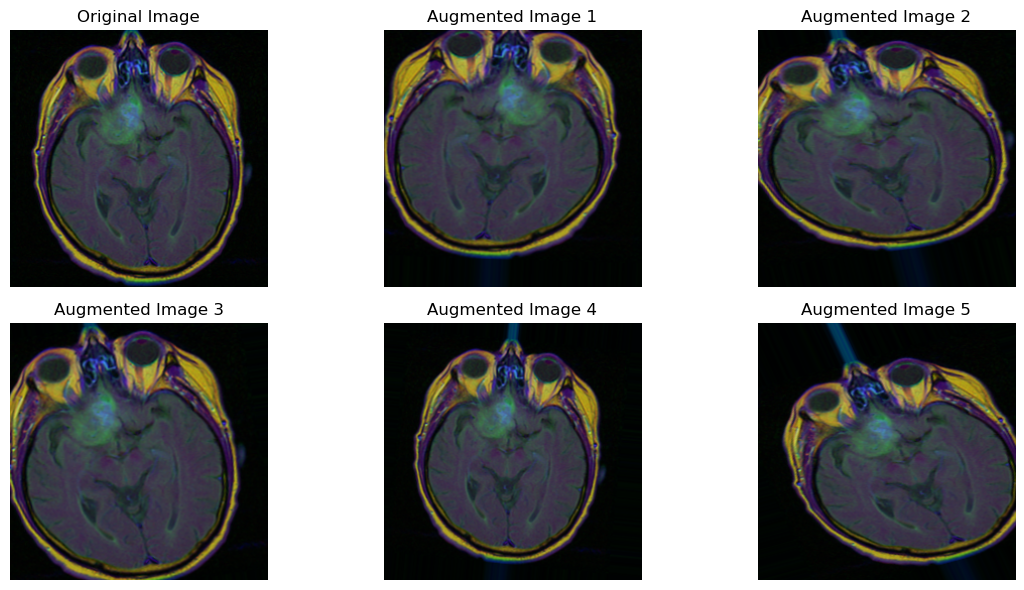

In [11]:
# Đường dẫn tới hình ảnh
image_path = '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif'

# Đọc hình ảnh ban đầu
image = plt.imread(image_path)

# Số lượng phiên bản mới muốn tạo ra
num_augmented_images = 5

# Tạo ra các phiên bản biến đổi của hình ảnh
augmented_images = []
for _ in range(num_augmented_images):
    augmented_image = train_datagen.random_transform(image)
    augmented_images.append(augmented_image)

# Hiển thị hình ảnh ban đầu và các phiên bản mới
plt.figure(figsize=(12, 6))

# Hình ảnh ban đầu
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Các phiên bản mới
for i in range(num_augmented_images):
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_images[i])
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [12]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=batch_size,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2201 validated image filenames belonging to 2 classes.
Found 942 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


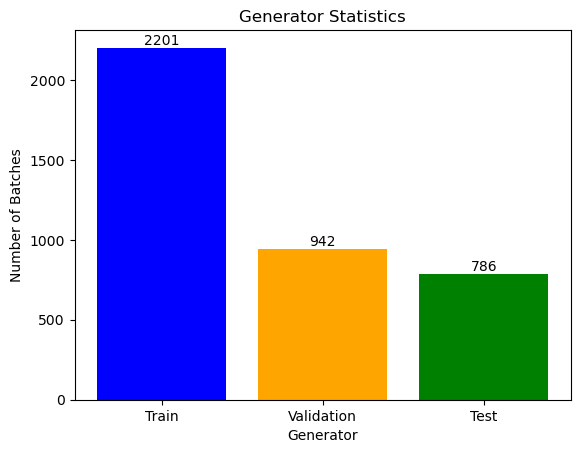

In [13]:
# Calculate the number of batches in each generator
train_steps = train_generator.n
valid_steps = valid_generator.n
test_steps = test_generator.n

# Create a list of labels for the x-axis
labels = ['Train', 'Validation', 'Test']

# Create a list of values for the y-axis
values = [train_steps, valid_steps, test_steps]

# Define the colors for each bar
colors = ['blue', 'orange', 'green']

# Plot the bar chart
plt.bar(labels, values, color=colors)
plt.xlabel('Generator')
plt.ylabel('Number of Batches')
plt.title('Generator Statistics')

# Add the numbers on top of the bars
for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()


#  Phân vùng
(seg)

In [14]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [15]:
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 1e-4
im_height=256
im_width=256

In [16]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [17]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
train_count = 2201
val_count = 942
test_count = 786

# Chia tập train ban đầu
df_train_temp, df_test = train_test_split(df, test_size=test_count, random_state=42)

# Chia tập train thành tập train và tập val
df_train, df_val = train_test_split(df_train_temp, test_size=val_count, random_state=42)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2201, 2)
(942, 2)
(786, 2)


In [18]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [19]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

# Hàm hỗ trợ
(TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE TUMOR)

In [20]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1
smooth=100


def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    binary_crossentropy_loss = K.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return binary_crossentropy_loss + dice_loss

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# Densenet121_Unet

In [21]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

In [22]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [23]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    return x
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
def build_densenet121_unet(input_size= (256,256,3)):
    """ Input """
    inputs = Input(input_size)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=(inputs))

    """ Encoder """
    s1 = densenet.get_layer(densenet.layers[0].name).output       ## 256
    s2 = densenet.get_layer("conv1/relu").output    ## 128
    s3 = densenet.get_layer("pool2_relu").output    ## 64
    s4 = densenet.get_layer("pool3_relu").output    ## 32

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 16

    """ Decoder """
    d1 = decoder_block(b1, s4, 256)             ## 32
    d2 = decoder_block(d1, s3, 128)             ## 64
    d3 = decoder_block(d2, s2, 64)             ## 128
    d4 = decoder_block(d3, s1, 32)              ## 256

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    display(tf.keras.utils.plot_model(model, to_file='model_densenet121_unet.png', show_shapes=True))
    return model

29084464/29084464 [==============================] - 0s 0us/step


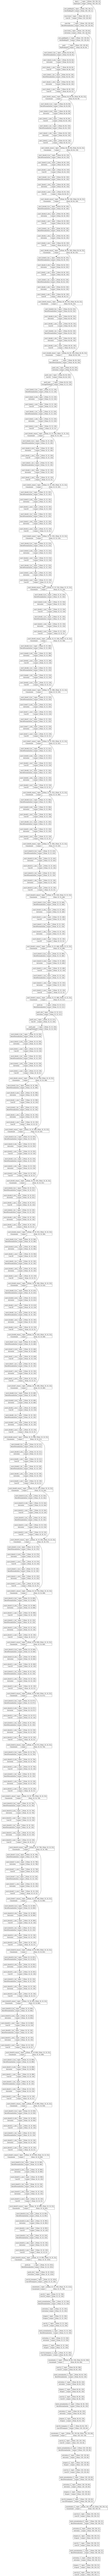

In [24]:
model_densenet121_unet = build_densenet121_unet(input_size=(256, 256, 3))

In [25]:
model_densenet121_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [26]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.001)
model_densenet121_unet.compile(optimizer = adam, 
                  loss = bce_dice_loss, 
                  metrics = [iou, dice_coef, 'accuracy']
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="seg_densenet121_unet.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
start_time = time.time()
history_densenet121_unet = model_densenet121_unet.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks = [checkpointer, earlystopping, reduce_lr],
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE
                 )
end_time = time.time()
densenet121_unet_time = end_time-start_time

Found 2201 validated image filenames.
Found 2201 validated image filenames.
Epoch 1/100


2023-06-26 08:17:49.778436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


138/137 [==============================] - ETA: 0s - loss: 1.2500 - iou: 0.0204 - dice_coef: 0.0392 - accuracy: 0.9296Found 942 validated image filenames.
Found 942 validated image filenames.

Epoch 1: val_loss improved from inf to 1.04532, saving model to seg_densenet121_unet.hdf5
137/137 [==============================] - 181s 765ms/step - loss: 1.2500 - iou: 0.0204 - dice_coef: 0.0392 - accuracy: 0.9296 - val_loss: 1.0453 - val_iou: 0.0166 - val_dice_coef: 0.0308 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 2/100
138/137 [==============================] - ETA: 0s - loss: 0.8569 - iou: 0.1306 - dice_coef: 0.2214 - accuracy: 0.9867
Epoch 2: val_loss improved from 1.04532 to 0.97107, saving model to seg_densenet121_unet.hdf5
137/137 [==============================] - 79s 575ms/step - loss: 0.8569 - iou: 0.1306 - dice_coef: 0.2214 - accuracy: 0.9867 - val_loss: 0.9711 - val_iou: 0.0489 - val_dice_coef: 0.0882 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 3/100
138/137 [========================

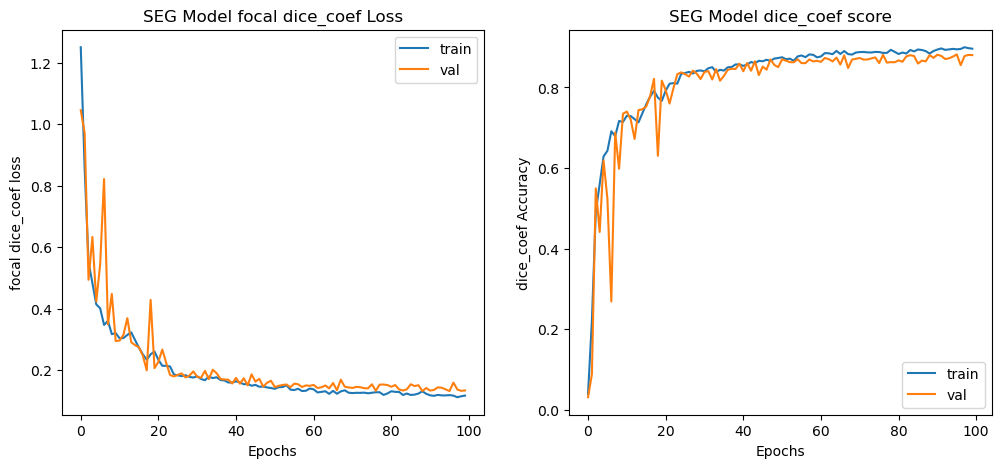

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_densenet121_unet.history['loss']);
plt.plot(history_densenet121_unet.history['val_loss']);
plt.title("SEG Model focal dice_coef Loss");
plt.ylabel("focal dice_coef loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history_densenet121_unet.history['dice_coef']);
plt.plot(history_densenet121_unet.history['val_dice_coef']);
plt.title("SEG Model dice_coef score");
plt.ylabel("dice_coef Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [28]:
densenet121_unet_time

7621.207444667816

In [29]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results_denseunet = model_densenet121_unet.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

print("Test lost {:.2f}%".format(results_denseunet[0]*100))
print("Test iou {:.2f}%".format(results_denseunet[1]*100))
print("Test Dice Coefficent: {:.2f}%".format(results_denseunet[2]*100))

Found 786 validated image filenames.
Found 786 validated image filenames.
49/49 [==============================] - 10s 207ms/step - loss: 0.1363 - iou: 0.7907 - dice_coef: 0.8806 - accuracy: 0.9977
Test lost 13.63%
Test iou 79.07%
Test Dice Coefficent: 88.06%


1/1 [==============================] - 3s 3s/step


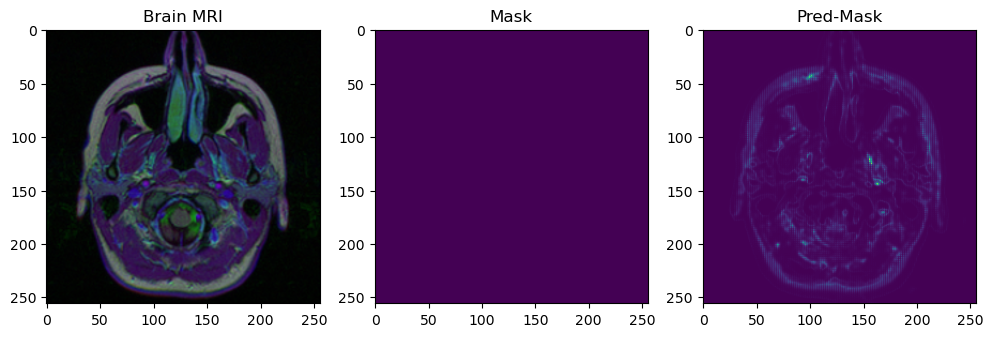

1/1 [==============================] - 0s 31ms/step


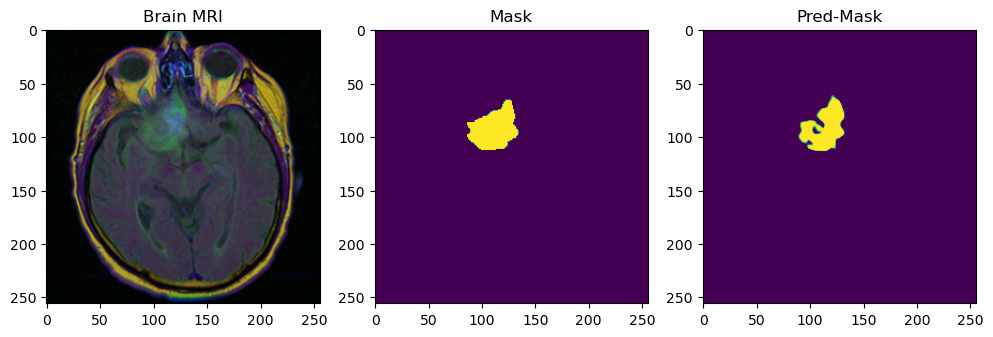

In [30]:
try:
    image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif')
    image=cv2.resize(image,dsize=(256,256))
    image=image /255.0
    image_ex=np.expand_dims(image,axis=0)
    image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif')
    image_mask=cv2.resize(image_mask,dsize=(256,256))
    image_mask=image_mask /255.0
    image_mask_ex=np.expand_dims(image_mask,axis=0)

    # Make prediction
    prediction = model_densenet121_unet.predict(image_ex)
    # Chuyển đổi đầu ra dự đoán và mặt nạ thực thành dạng nhị phân
    threshold = 0.5
    predicted_mask = np.round(prediction)
    true_mask = np.round(image_mask_ex)  # Thay true_mask bằng mặt nạ thực của bạn

    # Tính toán phần trăm chính xác
    accuracy = np.mean(predicted_mask == true_mask) * 100
    #print("Phần trăm chính xác: {:.2f}%".format(accuracy))
    # In kết quả

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Brain MRI");
    plt.subplot(1,3,2)
    plt.imshow(image_mask)
    plt.title("Mask");
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(prediction))
    plt.title("Pred-Mask");
    plt.show()
    print("===========================================================================================================")

    image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif')
    image=cv2.resize(image,dsize=(256,256))
    image=image /255.0
    image_ex=np.expand_dims(image,axis=0)
    image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif')
    image_mask=cv2.resize(image_mask,dsize=(256,256))
    image_mask=image_mask /255.0
    image_mask_ex=np.expand_dims(image_mask,axis=0)

    # Make prediction
    prediction = model_densenet121_unet.predict(image_ex)
   # Chuyển đổi đầu ra dự đoán và mặt nạ thực thành dạng nhị phân
    threshold = 0.5
    predicted_mask = np.round(prediction)
    true_mask = np.round(image_mask_ex)  # Thay true_mask bằng mặt nạ thực của bạn

    # Tính toán phần trăm chính xác
    accuracy = np.mean(predicted_mask == true_mask) * 100
    # In kết quả

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Brain MRI");
    plt.subplot(1,3,2)
    plt.imshow(image_mask)
    plt.title("Mask");
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(prediction))
    plt.title("Pred-Mask");
    plt.show()
except ValueError:
    print("Invalid input. Please enter integers only.")
except ZeroDivisionError:
    print("Error: Division by zero is not allowed.")
